In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np

clean_df = "/content/drive/MyDrive/Colab Notebooks/cleaned_constructor_dataset.csv"
clean_df = pd.read_csv(clean_df)
clean_df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,raceId,year,round,circuitId,month,dayofweek,constructorId,points_x,grid,position_x,...,season_wins,nationality,position_y,q1,q2,q3,sprint_grid,sprint_position,sprint_points,target
0,1,2009,1,1,3,6,23,18.0,1,1,...,1,British,1,85.1085,84.819,86.35350,9,11,0.0,0
1,1,2009,1,1,3,6,23,18.0,2,2,...,1,British,1,85.1085,84.819,86.35350,9,11,0.0,0
2,1,2009,1,1,3,6,1,0.0,12,40,...,0,British,14,86.3190,85.726,87.03225,9,11,0.0,0
3,1,2009,1,1,3,6,1,0.0,18,40,...,0,British,14,86.3190,85.726,87.03225,9,11,0.0,0
4,1,2009,1,1,3,6,7,11.0,20,3,...,0,Japanese,7,85.8465,85.273,87.05100,9,11,0.0,0


In [5]:
clean_df.columns

Index(['raceId', 'year', 'round', 'circuitId', 'month', 'dayofweek',
       'constructorId', 'points_x', 'grid', 'position_x', 'positionOrder',
       'points_y', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed',
       'standings_points', 'standings_position', 'season_wins', 'nationality',
       'position_y', 'q1', 'q2', 'q3', 'sprint_grid', 'sprint_position',
       'sprint_points', 'target'],
      dtype='object')

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor


🚀 Gradient Boosting Model for: standings_position
MAE  : 0.000
RMSE : 0.014
R²   : 1.000
±1 Accuracy : 99.98%


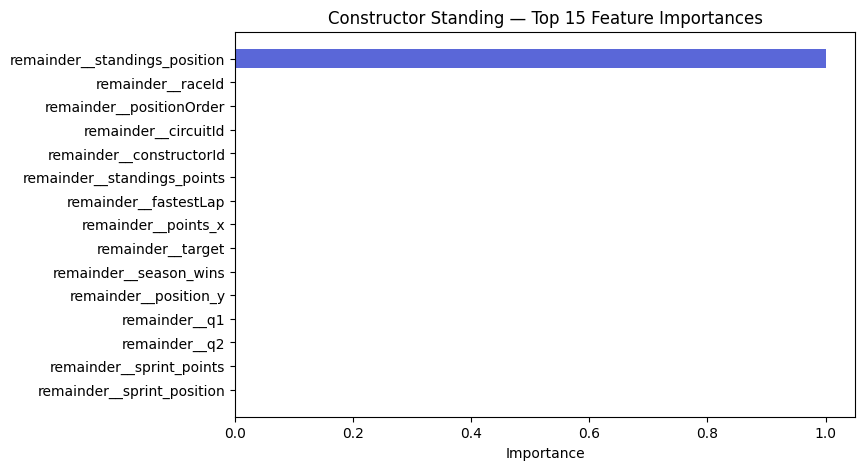

In [17]:


constructor_features = [
    'raceId', 'year', 'round', 'circuitId', 'month', 'dayofweek',
       'constructorId', 'points_x', 'grid', 'position_x', 'positionOrder',
       'points_y', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed',
       'standings_points', 'standings_position', 'season_wins', 'nationality',
       'position_y', 'q1', 'q2', 'q3', 'sprint_grid', 'sprint_position',
       'sprint_points', 'target'
]

TARGET_CONSTRUCTOR = 'standings_position'
categorical_cols = clean_df.select_dtypes(include=['object']).columns.tolist()

def train_boosted(df, target, features, categorical_cols, title_suffix):
    print(f"\n{'='*60}\n🚀 Gradient Boosting Model for: {target}\n{'='*60}")

    X = df[features]
    y = df[target]
    numeric_cols = [c for c in features if c not in categorical_cols]

    preprocessor = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
        remainder='passthrough'
    )

    model = Pipeline([
        ('prep', preprocessor),
        ('gbr', GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            random_state=42
        ))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    within1 = (np.abs(preds - y_test) <= 1).mean() * 100

    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R²   : {r2:.3f}")
    print(f"±1 Accuracy : {within1:.2f}%")

    # Visualization: Feature Importances
    model_stage = model.named_steps['gbr']
    feature_names = list(model.named_steps['prep'].get_feature_names_out())
    importances = model_stage.feature_importances_

    sorted_idx = np.argsort(importances)[-15:]
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color="#5A67D8")
    plt.title(f"{title_suffix} — Top 15 Feature Importances")
    plt.xlabel("Importance")
    plt.show()

    return model

# Train new boosted models
constructor_gb = train_boosted(clean_df, TARGET_CONSTRUCTOR, constructor_features, categorical_cols, "Constructor Standing")
